# Rosenblatt transformation

In this exercise, we will get introduced to sampling from correlated (dependent) variables using the Rosenblatt transformation. 

We consider 3 variables: wind speed $u$, turbulence $\sigma_u$, and wind shear exponent $\alpha$. The turbulence is considered conditionally dependent on the wind speed with distribution parameters: 
$\mu_(\sigma_u) (u)=I_{ref} (0.75u+3.8); \sigma_{\sigma_u} = 2.8 I_{ref} $ ; (Lognormal)

where $I_{ref} = 0.14$ is a constant;

and the wind shear explonent is also considered conditionally dependent on the wind speed:
$\mu_\alpha (u)=0.088(log⁡(u)−1); \sigma_{\alpha} (u)=1/u $; (Normal)



Our task is to generate a random sample (a "Monte Carlo simulation") of correlated wind speed, turbulence and wind shear realizations using the Rosenblatt transformation.

In [1]:
# Helper functions - normal distribution

# Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y


# Helper functions - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

In [34]:
import numpy as np
import scipy.stats as stats
from scipy import optimize
import scipy as sp # that is some inefficient importing ... 

# Define functions (inline functions for conditional distribution parameters)

Iref = 0.14; 

#--> for shear alpha
MuAlphaFunc = lambda u: 0.088*(np.log(u) - 1) #takes u, yields mu_alpha
SigmaAlphaFunc = lambda u: 1/u

#--> for turbulence sigma
MuSigmaFunc = lambda u: Iref*(0.75*u + 3.8)
SigmaSigmaU = 2.8*Iref

# Set up a Monte Carlo simulation using a Rosenblatt transformation

#-->params for monte carlo
N = 10000 # nsamples
Fu = np.random.rand(N) 

#-->params for Weibull distribution of U
Aweib = 11.28
Kweib = 2
u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib) # uses the weibull function to yield a large number of data

# calculate params for other 2 distributions, mu and sigma each
muSigma = MuSigmaFunc(u)
sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)

Fsigma = np.random.rand(N) # create new random sample
sigmaU = LogNormDist(2,Fsigma,muSigma,sigmaSigma) #draw monte carlo samples from distibution

muAlpha = MuAlphaFunc(u)
sigmaAlpha = SigmaAlphaFunc(u)
Falpha = np.random.rand(N)
alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)



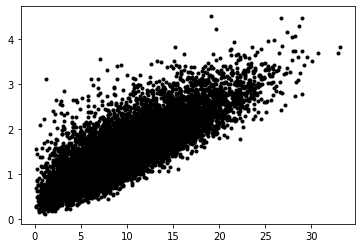

In [35]:
# Plot - wind speed vs. turbulence
import matplotlib.pyplot as plt
plt.plot(u,sigmaU,'.k')
plt.show()

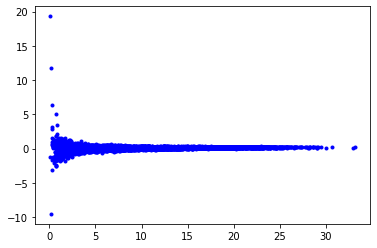

In [36]:
# Plot wind speed vs. wind shear
plt.plot(u,alpha,'.b')
plt.show()

In [37]:
###--------------- Tasks:

#1 Calibrate a simplified (surrogate) model of the extreme load function which maps the dependence
#  between the loads and the environmental conditions

#2 Devise a procedure which can determine the expected value of the blade root extreme load, as
#  function of a given joint distribution of wind speed, turbulence and wind shear

#3 Estimate what is the uncertainty in the estimated expected value of the extreme load - e.g. due to
#  model uncertainty and realization-to-realization uncertainty

#####------------ Structure and to dos 

#1 Set up programs needed to generate random samples (a Monte Carlo sample) from the joint
#  distribution of the environmental conditions. The dependence between variables is taken into
#  account using a Rosenblatt transformation
#-------> already given

#2 Run a crude Monte-Carlo simulation to obtain a reference for the expected value of the function.

#3 Choose the type(s) of surrogate models you want to calibrate – and select an appropriate
#  experimental design (e.g. a grid or just a crude Monte Carlo) to generate your training dataset.

#4 Calibrate the surrogate model(s) of your choice

#5 Evaluate the model performance and adequacy. Make e.g. one-to-one plots of true outputs vs.
#  model predictions, make a residual analysis (plot residuals vs. variables), calculate error terms (e.g.
#  r-square, RMS error, MAE) to evaluate the quality of the model fit and estimate model uncertainty

#6 Run a numerical simulation with the surrogate model to determine the expected value of the
#  function and compare with the results of the Monte Carlo

In [38]:
### To do 2: run crude monte carlo simualation,
#aim: use created wind data, to obtain an estimate of the loads.

#1 import function
import _utils as ut
#2 create input for function, as specified in the assignment
winddata = np.transpose(np.array([u,sigmaU,alpha]))
#2 plug wind data in function
loads = ut.MysteriousLoadFunc(winddata)
# have a look at the output
#3 calculate statistics for the loads



In [39]:
loads_mean = np.mean(loads)
loads_std = np.std(loads)
print(f"Mean of loads: {loads_mean} \t Std of loads: {loads_std} \n \
     These are only approximate values for this realisation of the Monte Carlo samples!")

Mean of loads: 63134.77507287241 	 Std of loads: 7951.6844827279965 
      These are only approximate values for this realisation of the Monte Carlo samples!


Text(0.5, 1.0, 'Loads over alpha')

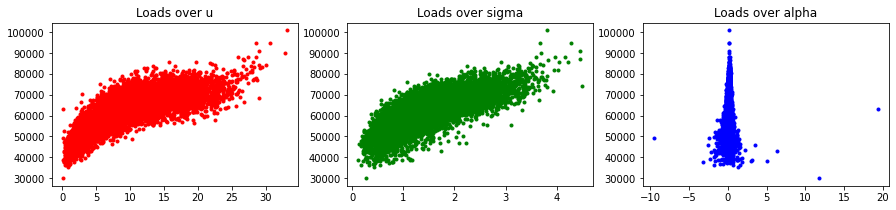

In [40]:
# lets have a look at the data
fig, axs = plt.subplots(1,3,figsize=[15,3])
axs[0].plot(winddata[:,0],loads,'.r')
axs[0].set_title("Loads over u")
axs[1].plot(winddata[:,1],loads,'.g')
axs[1].set_title("Loads over sigma")
axs[2].plot(winddata[:,2],loads,'.b')
axs[2].set_title("Loads over alpha")

In [41]:
###--------> 3 Choose the type(s) of surrogate models you want to calibrate – and select an appropriate
#            experimental design (e.g. a grid or just a crude Monte Carlo) to generate your training dataset.


In [42]:
### Try regression as in 4.2 

#necessary imports
import sklearn
import sklearn.neural_network
from sklearn.model_selection import train_test_split

#create Regression objects, try different ; 

#investigate the influence of hidden layers. Is it only computational time? Does accuracy vary?

#-------> verbose=True is interesting, but clutters the output

#parameters: 
no_change=10
MLP_max_iter = 750
reg_low_hidden_layers = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,10), activation='relu',learning_rate='adaptive',max_iter=MLP_max_iter,random_state=1,verbose=False,early_stopping=True,n_iter_no_change=no_change)
reg_high_hidden_layers = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,100), activation='relu',learning_rate='adaptive',max_iter=MLP_max_iter,random_state=1,verbose=False,early_stopping=True,n_iter_no_change=no_change)
reg_medium_hidden_layers = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,100,100), activation='relu',learning_rate='adaptive',max_iter=MLP_max_iter,random_state=1,verbose=False,early_stopping=True,n_iter_no_change=no_change)

# also create some to fit with scaled data, just to see if it changes something
reg_low_hidden_layers_scaled = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,10), activation='relu',learning_rate='adaptive',max_iter=MLP_max_iter,random_state=1,verbose=False,early_stopping=True,n_iter_no_change=no_change)
reg_high_hidden_layers_scaled = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,100), activation='relu',learning_rate='adaptive',max_iter=MLP_max_iter,random_state=1,verbose=False,early_stopping=True,n_iter_no_change=no_change)
reg_medium_hidden_layers_scaled = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,100,100), activation='relu',learning_rate='adaptive',max_iter=MLP_max_iter,random_state=1,verbose=False,early_stopping=True,n_iter_no_change=no_change)


# Create training and test data sets: (shown in documentation of MLPregressor)
# it would also work to just create a new training data set using the function ... there are many options
#--------> maybe kick out alpha -> there is not really something to see from regression I suppose. Let's try anyways
train_in, test_in, train_out, test_out = train_test_split(winddata,loads, test_size=0.25, random_state=1, shuffle=True)
# We might also need a scaled data set: #--------> Scaling before or after splitting? 
#----------> decide for before: statistical properties are "more representative" when used with bigger dataset. 
winddata_scaled = (winddata - winddata.mean(axis=0))/winddata.std(axis=0)
loads_scaled = ( loads - np.mean(loads) ) / np.std(loads)
train_in_scaled, test_in_scaled, train_out_scaled, test_out_scaled = train_test_split(winddata_scaled,loads_scaled, test_size=0.25, random_state=1, shuffle=True)

In [43]:
###------ Try to fit the models now. Several cells are used in order to fit individually
reg_low_hidden_layers.fit(train_in,train_out) # iteration number of 750 lets this one converge. Can we improve the convergence rate?

/home/mi/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(early_stopping=True, hidden_layer_sizes=(10, 10),
             learning_rate='adaptive', max_iter=750, random_state=1)

In [44]:
reg_low_hidden_layers_scaled.fit(train_in_scaled,train_out_scaled)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(10, 10),
             learning_rate='adaptive', max_iter=750, random_state=1)

In [45]:
reg_medium_hidden_layers.fit(train_in,train_out)
reg_medium_hidden_layers_scaled.fit(train_in_scaled,train_out_scaled)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100, 100),
             learning_rate='adaptive', max_iter=750, random_state=1)

In [46]:
reg_high_hidden_layers.fit(train_in,train_out)
reg_high_hidden_layers_scaled.fit(train_in_scaled,train_out_scaled)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 100),
             learning_rate='adaptive', max_iter=750, random_state=1)

Scores for low hidden layer number unscaled: [0.6747438430337829, 0.6709822411496529] 	 scaled: [0.7082593319533004, 0.7064526543245649]


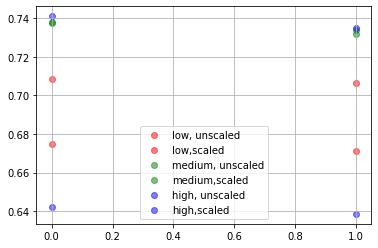

In [47]:
# look at the scoring ----> based on test data set / is it better to test on the full data set? 

rl1 = reg_low_hidden_layers.score(winddata,loads) #calibrated on unscaled, score for full data
rl2 = reg_low_hidden_layers.score(test_in, test_out) #calibrated on unscaled, score for full data
score_rl = [rl1,rl2]

#rls1 = reg_low_hidden_layers_scaled.score(winddata,loads) #calibrated on scaled, score for full data
#rls2 = reg_low_hidden_layers_scaled.score(test_in, test_out) #calibrated  unscaled, score for test data
rls1s = reg_low_hidden_layers_scaled.score(winddata_scaled,loads_scaled) #calibrated unscaled, score for full data
rls2s = reg_low_hidden_layers_scaled.score(test_in_scaled, test_out_scaled) #calibrated unscaled, score for test data
#score_rls = [rls1,rls2,rls1s,rls2s]
score_rls = [rls1s,rls2s]
print(f'Scores for low hidden layer number unscaled: {score_rl} \t scaled: {score_rls}')

### repeat for medium and high layer counts: 
#medium
rm1 = reg_medium_hidden_layers.score(winddata,loads) #calibrated on unscaled, score for full data
rm2 = reg_medium_hidden_layers.score(test_in, test_out) #calibrated on unscaled, score for test data
score_rm = [rm1,rm2]

#rms1 = reg_medium_hidden_layers_scaled.score(winddata,loads) #calibrated on scaled, score for full data
#rms2 = reg_medium_hidden_layers_scaled.score(test_in, test_out) #calibrated  unscaled, score for test data
rms1s = reg_medium_hidden_layers_scaled.score(winddata_scaled,loads_scaled) #calibrated unscaled, score for full data
rms2s = reg_medium_hidden_layers_scaled.score(test_in_scaled, test_out_scaled) #calibrated unscaled, score for test data
#score_rms = [rms1,rms2,rms1s,rms2s]
score_rms = [rms1s,rms2s]

#high
rh1 = reg_high_hidden_layers.score(winddata,loads) #calibrated on unscaled, score for full data
rh2 = reg_high_hidden_layers.score(test_in, test_out) #calibrated on unscaled, score for full data
score_rh = [rh1,rh2]

#rhs1 = reg_high_hidden_layers_scaled.score(winddata,loads) #calibrated on scaled, score for full data
#rhs2 = reg_high_hidden_layers_scaled.score(test_in, test_out) #calibrated  unscaled, score for test data
rhs1s = reg_high_hidden_layers_scaled.score(winddata_scaled,loads_scaled) #calibrated unscaled, score for full data
rhs2s = reg_high_hidden_layers_scaled.score(test_in_scaled, test_out_scaled) #calibrated unscaled, score for test data
#score_rhs = [rhs1,rhs2,rhs1s,rhs2s]
score_rhs = [rhs1s,rhs2s]

#Now visualize the scoring 
plt.figure()
plt.scatter(range(len(score_rl)),score_rl,label="low, unscaled",color='r',alpha=0.5)
plt.scatter(range(len(score_rls)),score_rls,label="low,scaled",color='r',alpha=0.5)

plt.scatter(range(len(score_rm)),score_rm,label="medium, unscaled",color='g',alpha=0.5)
plt.scatter(range(len(score_rms)),score_rms,label="medium,scaled",color='g',alpha=0.5)

plt.scatter(range(len(score_rh)),score_rh,label="high, unscaled",color='b',alpha=0.5)
plt.scatter(range(len(score_rhs)),score_rhs,label="high,scaled",color='b',alpha=0.5)

plt.grid()
plt.legend()

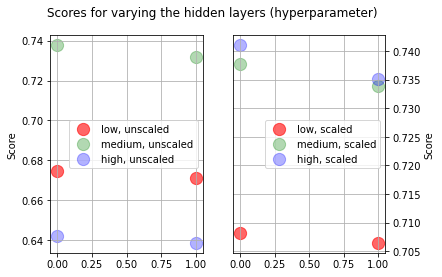

In [48]:
## So we can see, that they all end up in the same areas. Lets divide scaled and unscaled:
fig, axs = plt.subplots(1,2)
fig.suptitle("Scores for varying the hidden layers (hyperparameter)")
axs[0].scatter(range(len(score_rl)),score_rl,label="low, unscaled",color='r',alpha=0.6,s=150)
axs[0].scatter(range(len(score_rm)),score_rm,label="medium, unscaled",color='g',alpha=0.3,s=150)
axs[0].scatter(range(len(score_rh)),score_rh,label="high, unscaled",color='b',alpha=0.3,s=150)
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].grid()

axs[1].scatter(range(len(score_rls)),score_rls,label="low, scaled",color='r',alpha=0.6,s=150)
axs[1].scatter(range(len(score_rms)),score_rms,label="medium, scaled",color='g',alpha=0.3,s=150)
axs[1].scatter(range(len(score_rhs)),score_rhs,label="high, scaled",color='b',alpha=0.3,s=150)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set_ylabel("Score")
axs[1].legend()
axs[1].grid()

In [49]:
# What do these numbers mean now? 
# 1: perfect fit
# In 4.2, 9.x could be achieved
# so this is probably not the best regresion for the given data. It's not completely bad though (score lower 0 ) 
# scaling improves the score - but that might also be caused by how the score is computed. maybe smaller numbers -> better score.
# left: score on full data, right: score on test data. The model performs better on the full data, which is not surprising since it was trained on it.
# changing the hyperparameters does not achieve much better results. maybe a different kind of regression would be a good idea
# Maybe scores would be better without alpha in the input (see above)

In [50]:
# predict some data
#----> choose 1 or 2 of the models only ----> medium unscaled, medium scaled 
y_pred_scaled = reg_medium_hidden_layers_scaled.predict(test_in_scaled)
y_pred_unscaled = reg_medium_hidden_layers.predict(test_in)

# now it is very interesting: does the scaled regression also predict unscaled values? Probably not ?! 
y_pred_unscaled_from_scaled_model= reg_medium_hidden_layers_scaled.predict(test_in)#sorry for long names


<Figure size 432x288 with 0 Axes>

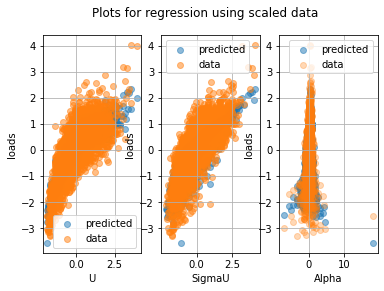

In [51]:
# plot the results for the regression using scaled
plt.figure()
fig, axs = plt.subplots(1,3)
fig.suptitle("Plots for regression using scaled data")

axs[0].scatter(test_in_scaled[:,0],y_pred_scaled,label="predicted",alpha=0.5)
axs[0].scatter(test_in_scaled[:,0],test_out_scaled,label="data",alpha=0.5)
axs[0].set_xlabel("U")

axs[1].scatter(test_in_scaled[:,1],y_pred_scaled,label="predicted",alpha=0.5)
axs[1].scatter(test_in_scaled[:,1],test_out_scaled,label="data",alpha=0.5)
axs[1].set_xlabel("SigmaU")

axs[2].scatter(test_in_scaled[:,2],y_pred_scaled,label="predicted",alpha=0.5)
axs[2].scatter(test_in_scaled[:,2],test_out_scaled,label="data",alpha=0.3)
axs[2].set_xlabel("Alpha")

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_ylabel("loads")

<Figure size 432x288 with 0 Axes>

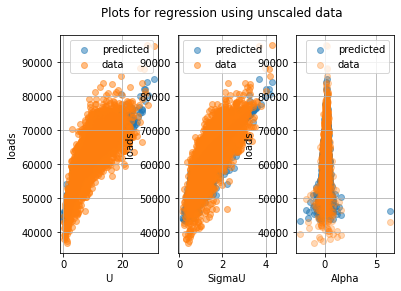

In [52]:
# plot the results for the regression using scaled
plt.figure()
fig, axs = plt.subplots(1,3)
fig.suptitle("Plots for regression using unscaled data")

axs[0].scatter(test_in[:,0],y_pred_unscaled,label="predicted",alpha=0.5)
axs[0].scatter(test_in[:,0],test_out,label="data",alpha=0.5)
axs[0].set_xlabel("U")

axs[1].scatter(test_in[:,1],y_pred_unscaled,label="predicted",alpha=0.5)
axs[1].scatter(test_in[:,1],test_out,label="data",alpha=0.5)
axs[1].set_xlabel("SigmaU")

axs[2].scatter(test_in[:,2],y_pred_unscaled,label="predicted",alpha=0.5)
axs[2].scatter(test_in[:,2],test_out,label="data",alpha=0.3)
axs[2].set_xlabel("Alpha")

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_ylabel("loads")

<Figure size 432x288 with 0 Axes>

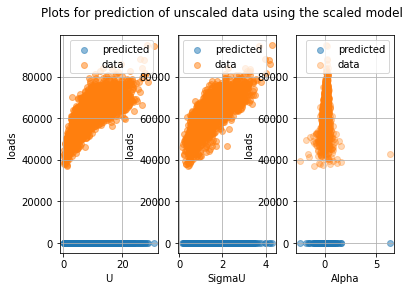

In [53]:
# plot the results for the regression using unscaled
plt.figure()
fig, axs = plt.subplots(1,3)
fig.suptitle("Plots for prediction of unscaled data using the scaled model")

axs[0].scatter(test_in[:,0],y_pred_unscaled_from_scaled_model,label="predicted",alpha=0.5)
axs[0].scatter(test_in[:,0],test_out,label="data",alpha=0.5)
axs[0].set_xlabel("U")

axs[1].scatter(test_in[:,1],y_pred_unscaled_from_scaled_model,label="predicted",alpha=0.5)
axs[1].scatter(test_in[:,1],test_out,label="data",alpha=0.5)
axs[1].set_xlabel("SigmaU")

axs[2].scatter(test_in[:,2],y_pred_unscaled_from_scaled_model,label="predicted",alpha=0.5)
axs[2].scatter(test_in[:,2],test_out,label="data",alpha=0.3)
axs[2].set_xlabel("Alpha")

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_ylabel("loads")

In [54]:
# We can clearly see, that this last attempt does not work. 
# Probably, rescaling is an option
# When using these models: You would probably scale everything that goes in and than look at metrics.

<Figure size 432x288 with 0 Axes>

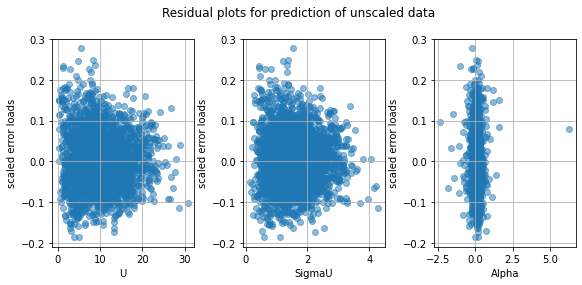

In [55]:
#Do some residual plots for the non scaled medium model: 
# plot the results for the regression using unscaled
plt.figure()
#plt.tight_layout()
fig, axs = plt.subplots(1,3,figsize=(8,4))
fig.suptitle("Residual plots for prediction of unscaled data")
y_err = (y_pred_unscaled - test_out)/test_out
axs[0].scatter(test_in[:,0],y_err,label="predicted",alpha=0.5)
#axs[0].scatter(test_in[:,0],test_out,label="data",alpha=0.5)
axs[0].set_xlabel("U")

axs[1].scatter(test_in[:,1],y_err,label="predicted",alpha=0.5)
#axs[1].scatter(test_in[:,1],test_out,label="data",alpha=0.5)
axs[1].set_xlabel("SigmaU")

axs[2].scatter(test_in[:,2],y_err,label="predicted",alpha=0.5)
#axs[2].scatter(test_in[:,2],test_out,label="data",alpha=0.3)
axs[2].set_xlabel("Alpha")
fig.tight_layout(w_pad=1.8)
for ax in axs:
    #ax.legend()
    ax.grid()
    ax.set_ylabel("scaled error loads") 
#plt.tight_layout

In [56]:
# Scores have  been computed before. But now, let's calculate some more error terms for the medium unscaled model
# r-square, RMS error, MAE)

# R² adjusted corrects for multiple parameters 
r_squared = rm1 # dummy value 
n= len(test_out) # number of samples
k= test_in.shape[1] # number of parameters
r_adjusted =1-  ( ((1-r_squared)*(n-1)) / (n-k-1 ) )
print(f"R_squared is {r_squared}, \t R squared adjusted is; {r_adjusted}")

#RMSE ;sqrt( (f-o)^2 ) 
rmse = np.sqrt((1/len(test_out))*np.sum(np.multiply(y_pred_unscaled-test_out,y_pred_unscaled-test_out))) # again the question is, whether to calculate it on the full data set or on the test data
#rmse = np.std(y_pred_unscaled - test_out) # would also work
print(f"The root mean square error is : {rmse}")

#MAE 
mae = (1/len(test_out))*np.sum(abs(y_pred_unscaled - test_out))

print(f"The mean absolute error is : {mae}")

R_squared is 0.7376868861386923, 	 R squared adjusted is; 0.7373716059537627
The root mean square error is : 4111.409271956633
The mean absolute error is : 3304.5305021356235


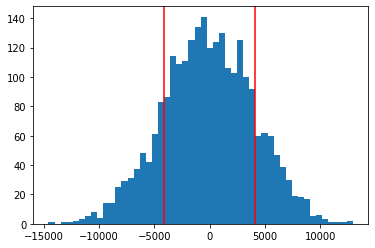

In [57]:
# It appears, that there is only slight difference between both R² values. It is not clear atm, whether these values can reallly be compared. 
# Maybe these values work better to compare different regressions, instead of being representative on its own. 
# The rmse as a number does not really say something on its own. maybe visualize it, using a histogram: 
plt.figure()
plt.hist(y_pred_unscaled - test_out,bins=50)
plt.axvline(rmse,color='r')
plt.axvline(-rmse,color='r')
#Showing the histogram of the distribution of absolute errors, and the rmse (standard deviation)  

In [180]:
def Vgumbel(alpha, beta, T, T0=1):
    """
    Parameters
    ----------
    alpha : 1st Gumbel parameter.
    beta : 2nd Gumbel parameter.
    T : return period.
    T0 : base period. The default is 1.

    Returns
    -------
    extreme wind speed.

    """
    return beta - alpha * np.log(np.log(1 / (1- T0/T)))

def PWM(Umax, T0=1, T50=50, chunksize=0):
    """
    Calculate the extreme wind according to a gumbel distribution which is fit 
    to the data with the probability weighted moments method.

    Parameters
    ----------
    Umax : maxima for each base period (default yearly).
    T0 : base period. The default is 1.
    T50 : return period. The default is 50.

    Returns
    -------
    alpha : gumbel parameter.
    beta : gumbel parameter.
    Vxtr : extreme wind.

    """
    
    if chunksize:
        Umax = np.random.permutation(Umax)
        Umax = np.reshape(Umax, [-1, chunksize])
        
    n = Umax.shape[-1]
    
    # rank the yearly maxima (along last axis)
    UmaxSorted = np.sort(Umax)
    
    # compute moments
    b0 = np.sum(Umax, -1)/n
    b1 = np.sum(np.multiply(np.arange(0, n), UmaxSorted), -1) / n / (n-1)
    
    # compute gumbel parameters
    gamma = 0.577
    alpha = (2*b1 - b0) / np.log(2)
    beta = b0 - gamma * alpha
    
    Vxtr = Vgumbel(alpha, beta, T50, T0=T0)
    
    return alpha, beta, Vxtr, b0, b1

Text(0.5, 1.0, 'Histogram of the extreme loads for 500 years of 1 year max values')

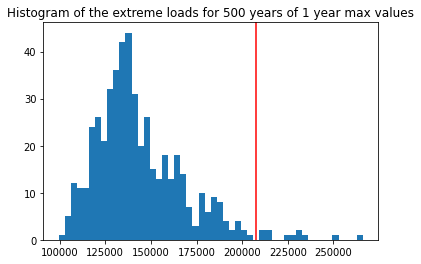

In [190]:
from scipy import optimize
# What happens, when a gumbel distribution is used for the input of u ? 
# Try estimating extreme loads. 
# 1) fit a gumbl on the extreme wind -> problem: no time information
# Assume that u is 10 min avg ! 
# Then fit gumbel to the input wind: 

#create 1year maxima 
#1 a year has how many 10 min intervals ? 
n_10min_year = 365*24*6 


#Create 1 year maxima
u_max = []
N_x = 500
for i in np.arange(500):
    r = stats.weibull_min.rvs(c = Kweib,scale = Aweib, size=n_10min_year)
    max_val = max(r)
    u_max.append(max_val) 
u_max = np.array(u_max)
# sort u data 
#u_max_sorted = np.sort(max_values)

#calc samples from that: 
muSigma_x = MuSigmaFunc(u_max)
sigmaSigma_x = SigmaSigmaU*np.ones(muSigma_x.shape)

Fsigma_x = np.random.rand(N_x) # create new random sample
sigmaU_x = LogNormDist(2,Fsigma_x,muSigma_x,sigmaSigma_x) #draw monte carlo samples from distibution

muAlpha_x = MuAlphaFunc(u_max)
sigmaAlpha_x = SigmaAlphaFunc(u_max)
Falpha_x = np.random.rand(N_x)
alpha_x = NormalDist(2,Falpha_x,muAlpha_x,sigmaAlpha_x)

max_wind_data = np.transpose(np.array([u_max,sigmaU_x,alpha_x]))
#2 plug wind data in function
loads_x = ut.MysteriousLoadFunc(max_wind_data)

loads_50_pwm = PWM(loads_x)



# 
#bnds = ((32,42),(1.6,2)) # is the range where the value will land. Was very unstable without
# Gumbel likelihood for umaxsorted
#gumbel_likelihood_max = lambda theta :-np.sum( np.log( abs(sp.stats.gumbel_r.pdf(loads_x,loc=theta[0],scale=theta[1]) ) )) # Definition of the negative log-likelihood function; Wsp is the windspeed
#gumbel_optimum_max = optimize.minimize(gumbel_likelihood_max,[36.95,1.85],bounds=bnds) # Minimization to find the optimal distribut=30.1 m/s

#Computing the 50 years wind
#loads_50 = gumbel_optimum_max.x[0] + gumbel_optimum_max.x[1]*np.log(50) # yields 50 year 

loads_50_pwm[2] # is the 50 year extreme load using pwm 
plt.hist(loads_x,bins=50) # just to see 
plt.axvline(loads_50_pwm[2],color='red')
plt.title(f"Histogram of the extreme loads for {N_x} years of 1 year max values")